# 7. Convex combination of normals
> Re-expressing Pagel's lambda with a convex combination of normals

In [2]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt


from tqdm import tqdm, trange

from src.phylogenetic_signal import PagelsLambda

# Global variables
N_SAMP = 100


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Numerical verification

In [3]:
# Intialize relevant objects
pl = PagelsLambda(tree="./seedplants/tree.nwk", format=0)

C = pl.C
N = pl.N

In [4]:
# Check for a random number
lam = np.random.rand() # Between 0 and 1

# Rescale the covariance matrix and sample from it
C_lam = pl.rescale_cov(lam, cov=C)

# Sample from this system
x = np.random.multivariate_normal(np.zeros(N), C_lam, size=N_SAMP)
lams = np.zeros(N_SAMP)
for i in range(N_SAMP):
    pl.fit(x[i, :].reshape(N, 1))
    lams[i] = pl.lam

print("Using rescaled covariance matrix:")
print("Mean:", np.mean(lams), "True:", lam)

Using rescaled covariance matrix:
Mean: 0.0344865430744579 True: 0.04690097118575298


In [5]:
# How does it look when we use a convex combination of the two covariance matrices?

C0 = pl.rescale_cov(0, cov=C)
C1 = pl.rescale_cov(1, cov=C)

C_lam_convex = lam * C1 + (1 - lam) * C0
assert np.allclose(C_lam, C_lam_convex)

C_sampled = np.cov(x.T)
print(np.sum(np.abs(C_lam - C_sampled)))

50.47239309614273


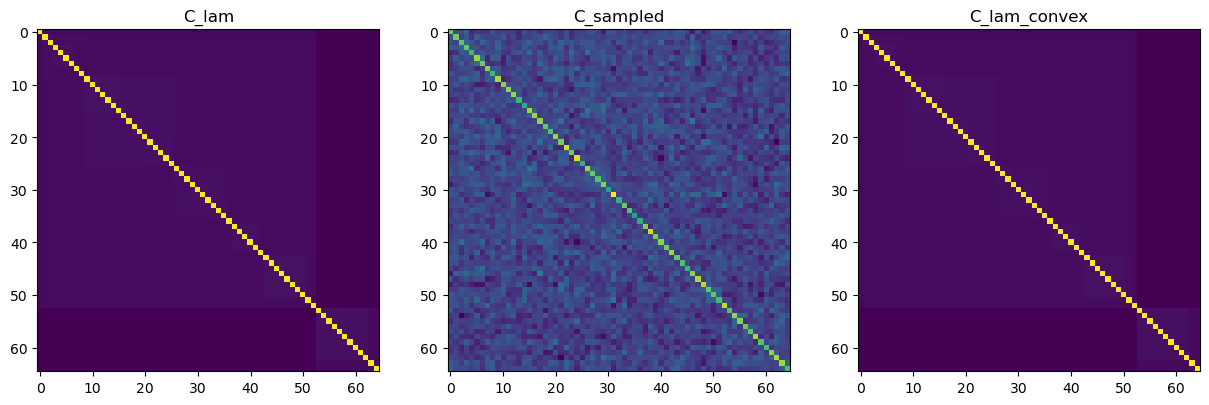

In [6]:
# Maybe plots will be more informatve:

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for ax, mat, name in zip(axs, [C_lam, C_sampled, C_lam_convex], ["C_lam", "C_sampled", "C_lam_convex"]):
    ax.imshow(mat)
    ax.set_title(name)

In [7]:
# Trying a search over lambdas

def loglikelihood(lam, x):
    C_lam = pl.rescale_cov(lam, cov=C)
    z0, sigma2, ll = pl.mle(x, C_lam, unbiased=True)
    return ll

lams_convex = np.zeros(N_SAMP)
for i in trange(N_SAMP):
    max_ll = -np.inf
    best_lam = None
    for candidate_lam in np.linspace(0, 1, 100):
        ll = loglikelihood(lam, x[i, :].reshape(N, 1))
        if ll > max_ll:
            max_ll = ll
            best_lam = lam
    lams_convex[i] = best_lam

print("Using convex combination of covariance matrices:")
print("Mean:", np.mean(lams_convex), "True:", lam) 

# Actually .80, I clobbered the true value
# But more importantly, the MLE is the same!

100%|██████████| 100/100 [00:34<00:00,  2.94it/s]

Using convex combination of covariance matrices:
Mean: 0.04690097118575299 True: 0.04690097118575298


# Developing an MLE framework

## Part 1: Determining means, variances, etc.

In [8]:
# What is z0 as a function of lambda?

# Get our component covariance matrices
C_0 = pl.rescale_cov(0, cov=C)
C_1 = pl.rescale_cov(1, cov=C)

# Get a random lambda
lam_true = np.random.rand()
z0_true = np.random.rand()
C_lam = pl.rescale_cov(lam_true, cov=C)

# Sample
x = np.random.multivariate_normal(z0_true * np.ones(N), C_lam, size=1).T

# Get MLE means and variances
z0_0, sigma2_0, ll_0 = pl.mle(x, C_0, unbiased=True)
z0_1, sigma2_1, ll_1 = pl.mle(x, C_1, unbiased=True)

# Assert that we know what these are:
assert np.allclose(z0_0, np.mean(x))

# For some random lambda, represent z0_MLE in terms of z0_0 and z0_1:
z0_mle, _, _ = pl.mle(x, C_lam, unbiased=True)
z0_convex = lam_true * z0_1 + (1 - lam_true) * z0_0

print(
    f"z0 (true):\t{z0_true:.3f}",
    f"z0 (MLE):\t{z0_mle:.3f}",
    f"z0 (convex):\t{z0_convex:.3f}",
    sep="\n"
)

# # Represent z0_random as a convex combination of z0_0 and z0_1
# z0_convex = random_lam * z0_1 + (1 - random_lam) * z0_0
# print("Convex combination:", z0_convex)

z0 (true):	0.070
z0 (MLE):	0.079
z0 (convex):	0.072


 So this is not quite right. I appear to be off by some small factor, whereas I
 want the MLE and convex to be exactly the same all the time. I will come back
 to this later.

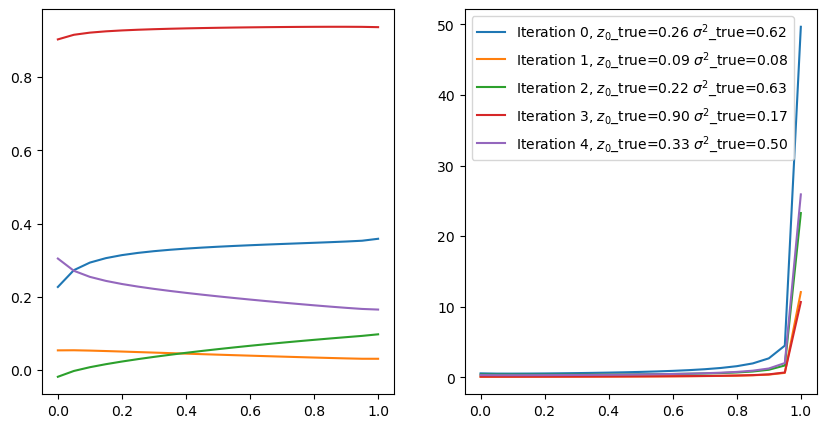

In [21]:
# What actually happens to the estimates of z0 by lambda?

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for it in range(5):
    # Get a random lambda
    lam_true = np.random.rand()
    z0_true = np.random.rand()
    sigma2_true = np.random.rand()
    C_lam = pl.rescale_cov(lam_true, cov=C)

    # Sample
    x = np.random.multivariate_normal(z0_true * np.ones(N), sigma2_true * C_lam, size=1).T

    z0s = []
    sigmas = []
    xs = np.linspace(0, 1, 21)
    for lam in xs:
        C_lam = pl.rescale_cov(lam, cov=C)
        z0, sigma2, ll = pl.mle(x, C_lam, unbiased=True)
        z0s.append(z0)
        sigmas.append(sigma2)
    axs[0].plot(xs, z0s)
    axs[1].plot(xs, sigmas, label=f"Iteration {it}, $z_0$_true={z0_true:.2f} $\sigma^2$_true={sigma2_true:.2f}")

    plt.legend()
plt.show()

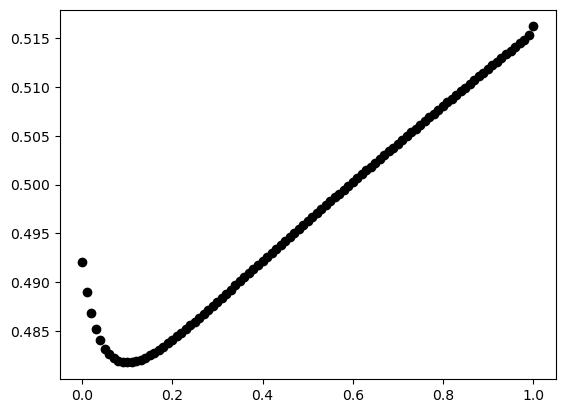

In [29]:
# Simpler version of z0 as a function of lambda

x = np.random.rand(N, 1)

for lam in np.linspace(0, 1, 101):
    C_lam = pl.rescale_cov(lam, cov=C)
    z0, sigma2, ll = pl.mle(x, C_lam, unbiased=True)
    plt.scatter(lam, z0, c="k")

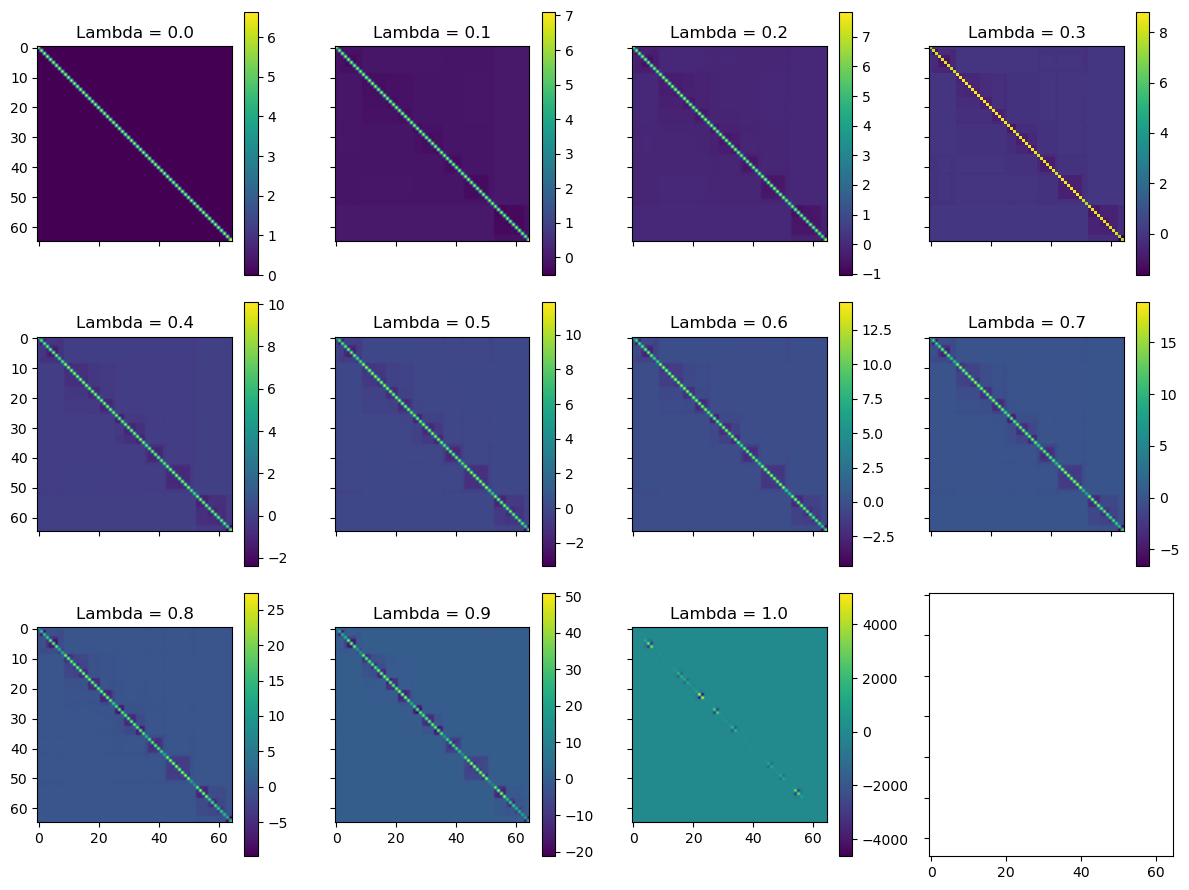

In [11]:
# What happens to C_lam^-1 as a function of lambda?

# Fuck it, we'll use subplots instead:
fig, axs = plt.subplots(
    3, 4, figsize=(12, 9), tight_layout=True, sharex=True, sharey=True
)
lam = 0
for i in range(3):
    for j in range(4):
        if lam <= 1:
            C_lam = pl.rescale_cov(lam=lam)
            m = axs[i, j].imshow(np.linalg.inv(C_lam))
            axs[i, j].set_title(f"Lambda = {lam:.1f}")
            lam += 0.1
            fig.colorbar(m, ax=axs[i, j])

# Well it certainly looks like a convex combination of inverses...


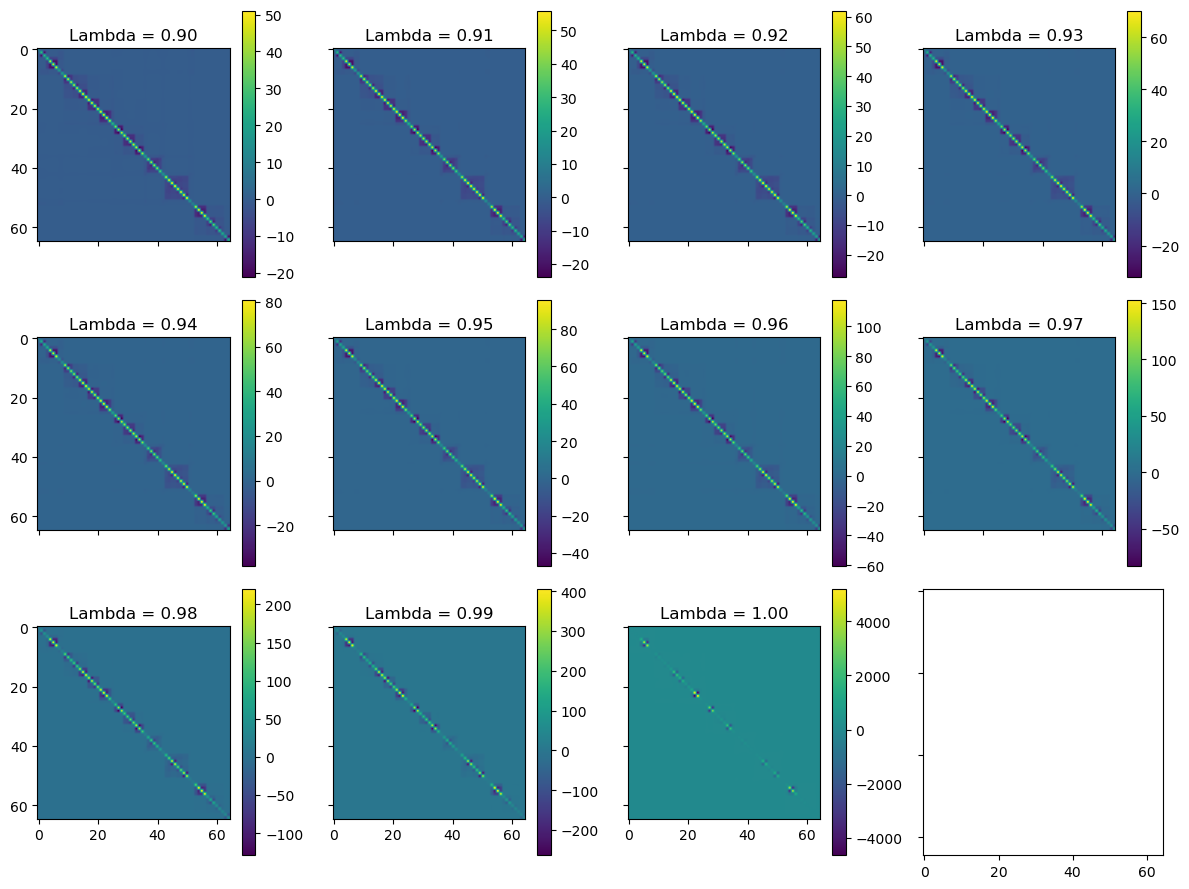

In [12]:
# Weird. What happens from .9 --> 1?

fig, axs = plt.subplots(
    3, 4, figsize=(12, 9), tight_layout=True, sharex=True, sharey=True
)
lam = 0.9
for i in range(3):
    for j in range(4):
        if lam <= 1:
            C_lam = pl.rescale_cov(lam=lam)
            m = axs[i, j].imshow(np.linalg.inv(C_lam))
            axs[i, j].set_title(f"Lambda = {lam:.2f}")
            lam += 0.01
            fig.colorbar(m, ax=axs[i, j])


0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
[431.4507230770089, 1093126.1302134986, 546057.7544428591, 363624.12719045486, 272320.4415893017, 217428.88878856515, 180682.97386417026, 154193.0277998936, 133842.43269008538, 116543.82836693423]


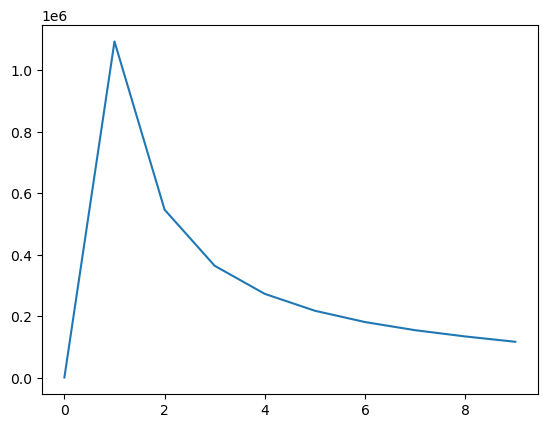

In [13]:
# Check numerically that C_lam^-1 = lam*C^-1 + (1-lam)*C_0^-1
# Use this: https://math.stackexchange.com/questions/17776/inverse-of-the-sum-of-matrices

# Base matrices
C = pl.C
C_0 = pl.rescale_cov(0)
C_inv = np.linalg.inv(C)
C_0_inv = np.linalg.inv(C_0)

# Check for a grid
errs = []
for lam in np.arange(0, 1, .1):
    print(lam)
    C_lam = pl.rescale_cov(lam)
    C_lam_inv = np.linalg.inv(C_lam)
    # C_lam_inv_convex = lam*C_inv + (1-lam)*C_0_inv
    A = lam*C
    A_inv = np.linalg.pinv(A)
    B = (1-lam)*C_0
    B_inv = np.linalg.pinv(B)

    # g = np.trace(((1-lam)*C_0) @ (lam * C_inv)) #BA^-1
    g = np.trace(B @ A_inv)
    h = 1 / (1 + g)
    C_lam_inv_convex = A_inv - h * A_inv @ B @ A_inv

    errs.append(np.abs(C_lam_inv - C_lam_inv_convex).sum())

print(errs)
plt.plot(errs)

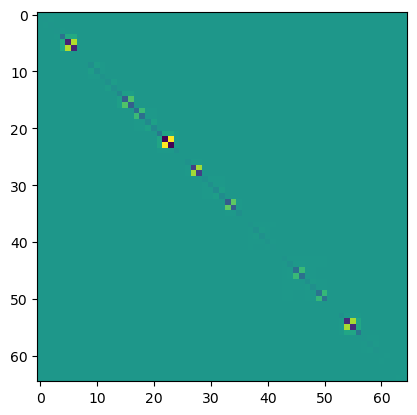

In [14]:
plt.imshow(C_lam_inv - C_lam_inv_convex)

In [15]:
# Does (1^T C_0^-1 1)(1^T C_0^-1 x) = mean(x)?

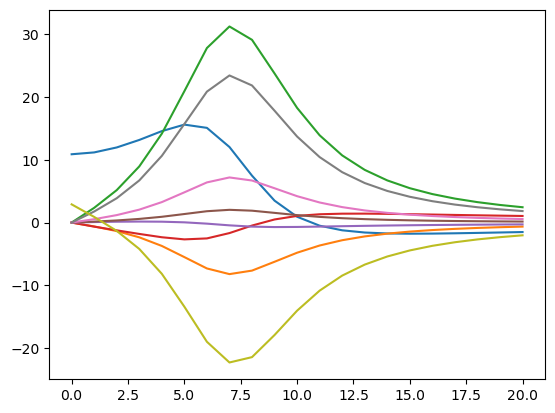

In [40]:
# 3x3 matrix case

a, b, c, d, e, f, g, h, i = np.random.rand(9)
# fig, axs = plt.subplots(7, 3, figsize=(6, 14))

lam = 0
vals = {}
for x in range(3):
    for y in range(3):
        vals[(x,y)] = []

for row in range(7):
    for col in range(3):
        det_C_lam = a * (e * i - lam**2 * f * h) - lam * b * (lam * d * i - lam**2 * f * g) + lam * c * (lam * d * h - e * lam * g)

        adjugate_C_lam = np.array([
            [(e * i - lam**2 * f * h), (lam * c * h - lam * b * i), (lam * b * f - lam * c * e)],
            [(lam**2 * f * g - lam * d * i), (lam * a * i - lam**2 * c * g), (lam * c * d - lam * a * f)],
            [(lam * d * h - e * lam * g), (lam * b * g - lam * a * h), (a * e - lam * b * d)]
        ])

        C_lam_inv = adjugate_C_lam / det_C_lam

        # axs[row, col].matshow(C_lam_inv)

        lam += .05

        for x in range(3):
            for y in range(3):
                vals[(x,y)].append(C_lam_inv[x, y])

for x in range(3):
    for y in range(3):
        plt.plot(vals[(x,y)], label=(x,y))

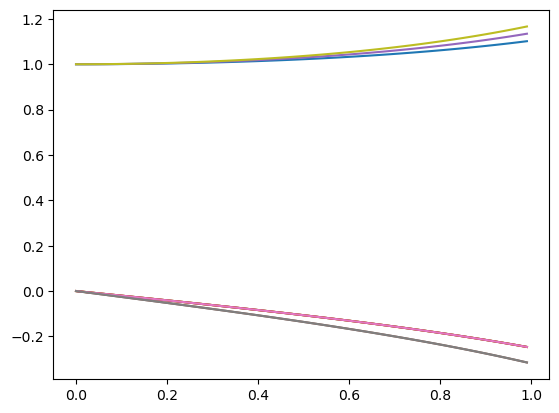

In [69]:
# 3x3 symmetric matrix case

a = d = f = 1
b, c, e = np.random.rand(3)

lam = 0
vals = {}
for x in range(3):
    for y in range(3):
        vals[(x,y)] = []

lams = []
for row in range(10):
    for col in range(10):
        lams.append(lam)
        det_C_lam = a * (d * f - lam**2 * e**2) - lam * b * (lam * b * f - lam * c * e) + lam * c * (lam * b * e - lam * c * d)

        adjugate_C_lam = np.array([
            [(d * f - lam**2 * e**2), -(lam * c * f - lam * b * e), (lam * b * e - lam * c * d)],
            [-(lam * c * f - lam * b * e), (a * f - lam**2 * c**2), -(lam * a * e - lam * b * c)],
            [(lam * b * e - lam * c * d), -(lam * a * e - lam * b * c), (a * d - lam**2 * b**2)]
        ])
        C_lam_inv = adjugate_C_lam / det_C_lam

        # axs[row, col].matshow(C_lam_inv)

        lam += .01

        for x in range(3):
            for y in range(3):
                vals[(x,y)].append(C_lam_inv[x, y])

for x in range(3):
    for y in range(3):
        plt.plot(lams, vals[(x,y)], label=(x,y))